<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E5%8A%A0%E5%85%A5IBP_EBP%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install catboost
from google.colab import drive
drive.mount('/content/drive')
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import warnings;warnings.simplefilter('ignore')
from sklearn.model_selection import cross_validate
from sklearn.linear_model import BayesianRidge, LinearRegression,Lasso,Ridge
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.scorer import make_scorer
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def mape(a, b):
    a ,b = np.array(a) ,np.array(b)
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

def rmse(y_t,y_p):
  return np.sqrt(mean_squared_error(y_t,y_p))

def metric(y_t,y_p,name):
  res = {'R2':np.clip(r2_score(y_t,y_p),0,1),
         'RMSE':rmse(y_t,y_p),
         'MAPE':mape(y_t,y_p)}
  return pd.DataFrame(res,index=[name])

def clean(df):
  condition = (df['N+A']>=36)
  return df.loc[condition]

def std_filter(df,num,cols=None):
  if cols == None:
    cols = df.columns
  for col in cols:
    ub = df[col].median() + num*df[col].std()
    lb = df[col].median() - num*df[col].std()
    df = df[(df[col] > lb)&(df[col] < ub)]
  df = df.dropna()
  return df

def get_result(y_test,y_pred):
  res = pd.DataFrame()
  for y_name in y_columns:
    row = metric(y_test[y_name],y_pred[y_name],y_name)
    res = res.append(row)
  res.loc['AVG'] = res.mean()
  return res

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def rule3(df):
  error_idx = []
  for idx in tqdm(df.index):
    row = df.loc[idx]
    c1 = (row['IBP']<row['T10'])&(row['T10']<row['T50'])&(row['T50']<row['T90'])&(row['T90']<row['EBP'])
    c2 = (np.sum(row[y_columns])>97)&(np.sum(row[y_columns])<102)
    c3 = (row['N+A'] < 70)
    if c1&c2&c3:
      pass
    else:
      error_idx.append(idx)
  if error_idx == []:
    print('pass check')
  else:
    print('error_num:{}'.format(len(error_idx)))
  return error_idx

# load

In [0]:
full = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/輕油實驗數據_保留絕大部份欄位.csv')
full.head()

,IBP,T5,T10,T30,T50,T70,T90,T95,EBP,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A,SUM
0,87.9,96.6,100.5,109.2,119.2,131.2,146.5,153.1,162.8,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.07,6.411,2.917,9.138,9.649,4.81,5.373,6.405,9.759,4.59,3.661,0.875,5.257,0.525,0.319,99.79300000000002
1,87.3,95.8,99.6,108.9,117.9,130.1,145.5,151.6,164.2,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.97,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303,98.881
2,88.7,96.2,100,109.1,118.8,130.7,145.6,152,164,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.89,9.006,9.591,4.778,5.468,6.36,9.983,4.274,2.979,0.865,5.641,0.964,0.289,98.83800000000001
3,88.6,96.5,100.4,109.1,118.6,129.4,142.9,147.2,159.4,31.453,0.224,0.105,0.060,4.894,2.497,2.65,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.51,6.444,10.182,4.42,2.964,0.830,5.637,0.968,0.281,98.80700000000002
4,88.4,96.2,100.4,108.8,118.1,129,142.2,146.5,158,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.5,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290,98.78299999999997


# define columns

In [0]:
cols = full.columns.tolist()
features = ['IBP','T10','T50','T90','EBP','N+A']
y_columns = cols[10:-1]

# numeric

In [0]:
for col in tqdm(full.columns):
  full[col] = pd.to_numeric(full[col],errors='coerce')

# drop nan inf

In [0]:
print(full.shape)
full = full.replace([np.inf,-np.inf],np.nan)
full = full.dropna(subset=features+y_columns)
print(full.shape)

(5309, 34)
(4801, 34)


#  N+A > 36 select

In [0]:
print(full.shape)
full = clean(full)
print(full.shape)

(4801, 34)
(2647, 34)


# 3 rule select

In [0]:
outliers = rule3(full)
print(full.shape)
full = full.drop(outliers)
print(full.shape)


error_num:75
(2647, 34)
(2572, 34)


# median + std filter

In [0]:
#print(full.shape)
#full = std_filter(full,3)
#print(full.shape)

# prepare X,y

In [0]:
X = full[features] - full[features].min()
X = X**2
X.describe()

,IBP,T10,T50,T90,EBP,N+A
count,2572.000000,2572.000000,2572.000000,2572.000000,2.572000e+03,2572.000000
mean,1845.321174,2067.455642,947.640210,520.254343,1.959423e+03,148.846823
std,1250.570533,839.339280,352.151246,225.025031,4.669022e+04,139.570033
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,880.607500,1608.010000,784.000000,396.010000,7.290000e+02,18.245719
50%,1705.690000,2218.410000,979.690000,501.760000,1.030410e+03,131.836349
75%,2490.010000,2621.440000,1157.702500,610.090000,1.260250e+03,237.791821
max,5791.210000,4369.210000,2570.490000,1849.000000,2.368829e+06,1124.126784


In [0]:
y = full[y_columns]
y.describe()

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
count,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000
mean,2.494607,1.671236,0.325752,3.525393,3.121456,5.081559,1.255728,6.530867,6.108705,13.294382,3.698913,6.347067,6.749366,8.249368,5.370450,3.639883,7.490804,4.917801,2.700858,0.893993,4.087788,0.759141,0.784174
std,2.191753,1.573939,0.401108,1.365921,1.694561,1.910433,2.487228,1.500853,1.142917,4.224883,1.473743,1.421867,1.490290,2.197846,1.968851,1.141394,1.634359,1.162992,0.946008,0.467318,1.229294,0.395149,0.532757
min,0.000000,0.000000,0.000000,0.076000,0.032000,0.019000,0.000000,0.163000,0.510000,0.829000,0.297000,0.000000,0.865000,0.663000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.129500,0.750750,0.171000,2.864750,2.056250,4.095250,0.503000,5.486750,5.175750,9.841250,3.219750,5.363000,5.837500,6.670750,4.511500,2.876750,6.385500,4.409000,2.141000,0.626500,3.513750,0.566000,0.433000
50%,1.798000,1.186000,0.289000,3.273500,2.877000,5.081500,0.613000,6.050500,6.102500,13.375000,3.454500,6.243000,6.630000,8.505500,5.294500,3.471500,7.459500,5.125500,2.629500,0.848000,4.143500,0.725000,0.679000
75%,2.950250,1.857000,0.365250,4.058000,3.806000,5.665500,0.930000,7.230500,6.930500,15.860500,3.964000,7.127250,7.616750,9.776750,5.952250,4.115250,8.615000,5.665250,3.115250,1.161250,4.723750,0.891000,0.955250
max,14.751000,16.888000,10.297000,21.180000,21.486000,24.077000,20.879000,11.090000,12.050000,27.038000,45.588000,10.438000,19.006000,30.747000,33.813000,13.501000,13.027000,11.678000,18.443000,6.288000,26.204000,6.622000,5.279000


# split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 ,random_state=42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(2057, 6) (515, 6)
(2057, 23) (515, 23)


# modeling

In [0]:
base = CatBoostRegressor(learning_rate = 0.1,n_estimators=100,verbose=1,objective='RMSE')
model = MultiOutputRegressor(base)
model.fit(X_train,y_train)

0:	learn: 1.9825033	total: 48.7ms	remaining: 4.82s
1:	learn: 1.8221923	total: 51ms	remaining: 2.5s
2:	learn: 1.6780560	total: 53.1ms	remaining: 1.72s
3:	learn: 1.5476094	total: 55.2ms	remaining: 1.32s
4:	learn: 1.4294264	total: 57.4ms	remaining: 1.09s
5:	learn: 1.3253890	total: 59.4ms	remaining: 931ms
6:	learn: 1.2299887	total: 61.6ms	remaining: 818ms
7:	learn: 1.1486626	total: 63.6ms	remaining: 732ms
8:	learn: 1.0757643	total: 65.8ms	remaining: 665ms
9:	learn: 1.0105408	total: 67.8ms	remaining: 611ms
10:	learn: 0.9537376	total: 69.9ms	remaining: 565ms
11:	learn: 0.9045708	total: 71.9ms	remaining: 527ms
12:	learn: 0.8611075	total: 74ms	remaining: 495ms
13:	learn: 0.8220586	total: 76.1ms	remaining: 468ms
14:	learn: 0.7873411	total: 78.2ms	remaining: 443ms
15:	learn: 0.7561964	total: 80.3ms	remaining: 421ms
16:	learn: 0.7266302	total: 82.4ms	remaining: 402ms
17:	learn: 0.7011051	total: 84.5ms	remaining: 385ms
18:	learn: 0.6811567	total: 87.3ms	remaining: 372ms
19:	learn: 0.6639575	total:

MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x7f8638b866d8>,
                     n_jobs=None)

# predict and metric

In [0]:
y_pred = pd.DataFrame(model.predict(X_test),columns=y_columns,index=y_test.index)
res = get_result(y_test,y_pred)
res.style.background_gradient()

,R2,RMSE,MAPE
C5NP,0.967411,0.418925,0.398219
C5IP,0.950266,0.371173,0.781032
C5N,0.0504729,0.318179,0.361722
C6NP,0.922848,0.36682,0.0896549
C6IP,0.948069,0.386451,0.113675
C6N,0.830555,0.772788,0.153713
C6A,0.871229,0.98394,0.344088
C7NP,0.913316,0.440123,0.0519947
C7IP,0.801798,0.481055,0.0594697
C7N,0.916036,1.23742,0.0896831


# count loss

In [0]:
loss = np.sqrt(np.square(y_test-y_pred))

# plot loss

In [0]:
y_name = 'C8A'
plot_data = X_test
plot_data[y_name] = y_test[y_name]
plot_data[y_name+'_pred'] = y_pred[y_name]
plot_data['loss'] = loss[y_name]
plot_data['index'] = X_test.index
fig = px.scatter(plot_data, x = y_name , y = "loss" ,color = "loss",size = "loss",hover_data=plot_data.columns)
fig.show()

In [0]:
high_loss_index = plot_data['loss'].sort_values(ascending=False).index
high_loss_index[:10]

Int64Index([928, 1280, 4450, 4449, 4414, 4205, 2511, 2454, 4466, 2503], dtype='int64')

In [0]:
higlight_index = high_loss_index[0]
pred_like_index = list(abs(plot_data[y_name+'_pred'] - plot_data.loc[higlight_index,y_name+'_pred']).sort_values().index[1:2])
test_like_index = list(abs(plot_data[y_name] - plot_data.loc[higlight_index,y_name]).sort_values().index[1:2])

# 觀察兩筆

,IBP,T10,T50,T90,EBP,N+A,C8A,C8A_pred,loss
928,635.04,1232.01,967.21,650.25,1024,110.502,13.345,5.0073,8.3377
1699,870.25,1755.61,900,576,1036.84,141.158,4.692,5.00049,0.308487


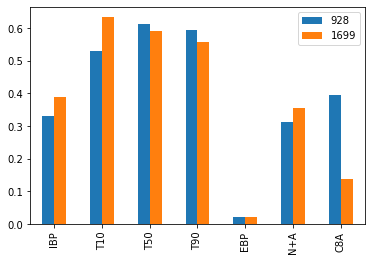

In [0]:
compare_data = plot_data.loc[[higlight_index]+pred_like_index]
scaler = MinMaxScaler()
full[features+[y_name]] = scaler.fit_transform(full[features+[y_name]])
full.loc[compare_data.index,features+[y_name]].T.plot(kind='bar')
compare_data.iloc[:,:-1].style.background_gradient(axis=1)